# Visualização de Blocos YUV 4:2:0 (8-bit e 10-bit LOSSLESS)

Este notebook visualiza os blocos de vídeo YUV salvos como arquivos binários pelos scripts de extração.

**Funcionalidades:**
- ✅ **Detecção automática** de formato: 8-bit (uint8) ou 10-bit LOSSLESS (uint16)
- ✅ Carregamento direto dos arquivos binários do diretório `intra_raw_blocks`
- ✅ Visualização de N blocos aleatórios do tamanho especificado
- ✅ Estatísticas básicas dos blocos (média, desvio padrão, min, max)
- ✅ Grid de visualização limpo e organizado
- ✅ Histogramas de intensidade
- ✅ Compatibilidade com arquivos antigos (8-bit) e novos (10-bit LOSSLESS)

**Formato dos dados suportados:**

1. **Arquivos 8-bit (scripts antigos)**:
   - Tipo: uint8
   - Range: 0-255
   - Conversão: 10-bit → 8-bit (com perda)

2. **Arquivos 10-bit LOSSLESS (novo script)**:
   - Tipo: uint16 little-endian
   - Range: 0-1023
   - Precisão: Completa, sem perda

**Tamanhos suportados:** 64×64, 32×32, 16×16, 8×8 pixels

In [80]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random
from pathlib import Path

# Configuração para melhor qualidade das imagens
#plt.rcParams['figure.dpi'] = 100
#plt.rcParams['savefig.dpi'] = 150

In [81]:
# Helper Functions
def extract_info_from_filename(filename):
    """
    Extrai informações do nome do arquivo de blocos.
    Exemplo: '11_NewsClip_1080P-27fb_sample_16.txt' -> sequence_name='11_NewsClip_1080P-27fb', block_size=16
    """
    basename = os.path.basename(filename)
    name_without_ext = os.path.splitext(basename)[0]
    
    # Dividir por '_sample_'
    parts = name_without_ext.split('_sample_')
    if len(parts) == 2:
        sequence_name = parts[0]
        block_size = int(parts[1])
        return sequence_name, block_size
    else:
        raise ValueError(f"Formato de arquivo não reconhecido: {basename}")

def detect_file_format(filepath, block_size):
    """
    Detecta automaticamente se o arquivo é 8-bit (uint8) ou 10-bit LOSSLESS (uint16).
    
    Args:
        filepath: Caminho para o arquivo
        block_size: Tamanho esperado do bloco
        
    Returns:
        dict com informações: {'dtype': np.uint8 ou np.uint16, 'bit_depth': 8 ou 10, 'max_value': 255 ou 1023}
    """
    file_size = os.path.getsize(filepath)
    pixels_per_block = block_size * block_size
    
    # Calcular número de blocos para cada formato
    n_blocks_8bit = file_size // (pixels_per_block * 1)  # 1 byte/pixel
    n_blocks_10bit = file_size // (pixels_per_block * 2)  # 2 bytes/pixel
    
    # Verificar qual é múltiplo exato
    is_8bit = (file_size % (pixels_per_block * 1) == 0) and n_blocks_8bit > 0
    is_10bit = (file_size % (pixels_per_block * 2) == 0) and n_blocks_10bit > 0
    
    if is_10bit and not is_8bit:
        # Definitivamente 10-bit
        return {
            'dtype': np.uint16,
            'dtype_str': '<u2',  # uint16 little-endian
            'bit_depth': 10,
            'max_value': 1023,
            'bytes_per_pixel': 2,
            'n_blocks': n_blocks_10bit,
            'format_name': '10-bit LOSSLESS'
        }
    elif is_8bit and not is_10bit:
        # Definitivamente 8-bit
        return {
            'dtype': np.uint8,
            'dtype_str': 'u1',  # uint8
            'bit_depth': 8,
            'max_value': 255,
            'bytes_per_pixel': 1,
            'n_blocks': n_blocks_8bit,
            'format_name': '8-bit'
        }
    elif is_8bit and is_10bit:
        # Ambíguo - tentar ler e verificar range de valores
        # Assumir 10-bit se tamanho é par
        if file_size % 2 == 0:
            return {
                'dtype': np.uint16,
                'dtype_str': '<u2',
                'bit_depth': 10,
                'max_value': 1023,
                'bytes_per_pixel': 2,
                'n_blocks': n_blocks_10bit,
                'format_name': '10-bit LOSSLESS (detectado)'
            }
        else:
            return {
                'dtype': np.uint8,
                'dtype_str': 'u1',
                'bit_depth': 8,
                'max_value': 255,
                'bytes_per_pixel': 1,
                'n_blocks': n_blocks_8bit,
                'format_name': '8-bit (detectado)'
            }
    else:
        raise ValueError(f"Tamanho de arquivo inválido: {file_size} bytes não corresponde a {block_size}×{block_size} blocos")

def load_partition_labels(labels_dir, sequence_name, block_size):
    """
    Carrega as labels de particionamento correspondentes aos blocos.
    
    Args:
        labels_dir: Diretório contendo os arquivos de labels
        sequence_name: Nome da sequência (ex: '11_NewsClip_1080P-27fb')
        block_size: Tamanho do bloco
        
    Returns:
        np.ndarray: Array com as labels de particionamento
    """
    try:
        # Construir o nome do arquivo de labels no formato correto
        # Padrão: 'YachtRide_3840x2160_120fps_420_10bit_labels_16_intra.txt'
        label_filename = f"{sequence_name}_labels_{block_size}_intra.txt"
        label_filepath = os.path.join(labels_dir, label_filename)
        
        if not os.path.exists(label_filepath):
            print(f"AVISO: Arquivo de labels não encontrado: {label_filepath}")
            return None
            
        # Carregar labels como texto e converter para int
        # O arquivo contém uma label por linha
        with open(label_filepath, 'r') as f:
            lines = f.readlines()
            labels = np.array([int(line.strip()) for line in lines if line.strip()])
        
        return labels
        
    except Exception as e:
        print(f"ERRO ao carregar labels de {label_filepath}: {e}")
        return None

def load_binary_blocks(filepath, block_size):
    """
    Carrega blocos binários do arquivo e os converte para arrays 2D.
    DETECTA AUTOMATICAMENTE se é 8-bit ou 10-bit LOSSLESS.
    
    Args:
        filepath: Caminho para o arquivo binário
        block_size: Tamanho do bloco (ex: 16 para blocos 16x16)
    
    Returns:
        tuple: (blocks_array, format_info)
            blocks_array: Array 3D com shape (n_blocks, block_size, block_size)
            format_info: Dict com informações do formato detectado
    """
    try:
        # Detectar formato do arquivo
        format_info = detect_file_format(filepath, block_size)
        
        # Carregar dados com dtype correto
        data = np.fromfile(filepath, dtype=format_info['dtype_str'])
        
        # Validar número de pixels
        pixels_per_block = block_size * block_size
        n_blocks = format_info['n_blocks']
        
        if len(data) != n_blocks * pixels_per_block:
            print(f"AVISO: Tamanho inesperado em {os.path.basename(filepath)}")
            # Truncar para múltiplo exato
            data = data[:n_blocks * pixels_per_block]
        
        # Validar range de valores
        min_val = np.min(data)
        max_val = np.max(data)
        
        if max_val > format_info['max_value']:
            print(f"AVISO: Valores fora do range esperado ({max_val} > {format_info['max_value']})")
        
        # Adicionar informações estatísticas ao format_info
        format_info['actual_min'] = int(min_val)
        format_info['actual_max'] = int(max_val)
        format_info['actual_mean'] = float(np.mean(data))
        
        # Reshape para (n_blocks, block_size, block_size)
        blocks = data.reshape(n_blocks, block_size, block_size)
        
        return blocks, format_info
    
    except Exception as e:
        print(f"ERRO ao carregar {filepath}: {e}")
        return None, None

def get_block_statistics(block):
    """Calcula estatísticas básicas de um bloco."""
    return {
        'mean': np.mean(block),
        'std': np.std(block),
        'min': np.min(block),
        'max': np.max(block)
    }

def get_partition_mode_name(mode_index):
    """Converte índice do modo de particionamento para nome."""
    partition_modes = [
        "PARTITION_NONE",
        "PARTITION_HORZ", 
        "PARTITION_VERT",
        "PARTITION_SPLIT",
        "PARTITION_HORZ_A",
        "PARTITION_HORZ_B", 
        "PARTITION_VERT_A",
        "PARTITION_VERT_B",
        "PARTITION_HORZ_4",
        "PARTITION_VERT_4"
    ]
    
    if 0 <= mode_index < len(partition_modes):
        return partition_modes[mode_index]
    else:
        return f"UNKNOWN_{mode_index}"

In [82]:
# Configurar diretório e descobrir arquivos disponíveis
intra_blocks_dir = "/home/chiarorosa/experimentos/uvg/intra_raw_blocks"

# Buscar todos os arquivos de blocos
block_files = []
for directory in glob.glob(intra_blocks_dir):
    pattern = os.path.join(directory, "*_sample_*.txt")
    files = glob.glob(pattern)
    block_files.extend(files)

print(f"📁 Arquivos de blocos encontrados: {len(block_files)}")

# Agrupar por tamanho de bloco
files_by_size = {}
for filepath in block_files:
    try:
        _, block_size = extract_info_from_filename(filepath)
        if block_size not in files_by_size:
            files_by_size[block_size] = []
        files_by_size[block_size].append(filepath)
    except Exception as e:
        print(f"AVISO: Ignorando arquivo {os.path.basename(filepath)}: {e}")

print("\n📊 Distribuição por tamanho de bloco:")
for size in sorted(files_by_size.keys()):
    print(f"  {size}x{size}: {len(files_by_size[size])} arquivos")

# Exibir exemplos de arquivos
print("\n📄 Exemplos de arquivos encontrados:")
for i, filepath in enumerate(block_files[:5]):
    try:
        seq_name, block_size = extract_info_from_filename(filepath)
        file_size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  {i+1}. {os.path.basename(filepath)} - {seq_name} - {block_size}x{block_size} - {file_size_mb:.2f} MB")
    except:
        print(f"  {i+1}. {os.path.basename(filepath)} - Formato não reconhecido")

📁 Arquivos de blocos encontrados: 64

📊 Distribuição por tamanho de bloco:
  8x8: 16 arquivos
  16x16: 16 arquivos
  32x32: 16 arquivos
  64x64: 16 arquivos

📄 Exemplos de arquivos encontrados:
  1. Bosphorus_3840x2160_120fps_420_10bit_sample_8.txt - Bosphorus_3840x2160_120fps_420_10bit - 8x8 - 9.13 MB
  2. Jockey_3840x2160_120fps_420_10bit_sample_32.txt - Jockey_3840x2160_120fps_420_10bit - 32x32 - 14.65 MB
  3. SunBath_3840x2160_50fps_420_10bit_sample_8.txt - SunBath_3840x2160_50fps_420_10bit - 8x8 - 7.46 MB
  4. FlowerPan_3840x2160_50fps_420_10bit_sample_32.txt - FlowerPan_3840x2160_50fps_420_10bit - 32x32 - 15.89 MB
  5. ShakeNDry_3840x2160_120fps_420_10bit_sample_16.txt - ShakeNDry_3840x2160_120fps_420_10bit - 16x16 - 14.37 MB


In [83]:
print(f"🎯 Configuração:")

# PARÂMETROS DE VISUALIZAÇÃO - CONFIGURE AQUI
block_size = 16  # Tamanho do bloco desejado (8, 16, 32, ou 64)
n_blocks_to_show = 100  # Número de blocos a visualizar
colormap = 'gray'  # Mapa de cores ('gray', 'viridis', 'hot', 'cool')
grid_cols = 10  # Número de colunas no grid

print(f"  Tamanho do bloco: {block_size}x{block_size}")
print(f"  Número de blocos: {n_blocks_to_show}")
print(f"  Mapa de cores: {colormap}")
print(f"  Colunas no grid: {grid_cols}")

# Verificar se temos arquivos para o tamanho solicitado
if block_size not in files_by_size:
    print(f"\n❌ ERRO: Não foram encontrados arquivos com blocos {block_size}x{block_size}")
    print(f"Tamanhos disponíveis: {list(files_by_size.keys())}")
else:
    available_files = files_by_size[block_size]
    print(f"\n✅ Encontrados {len(available_files)} arquivos com blocos {block_size}x{block_size}")

🎯 Configuração:
  Tamanho do bloco: 16x16
  Número de blocos: 100
  Mapa de cores: gray
  Colunas no grid: 10

✅ Encontrados 16 arquivos com blocos 16x16


In [84]:
# Carregar e amostrar blocos aleatórios
labels_dir = "/home/chiarorosa/experimentos/uvg/labels"

if block_size in files_by_size:
    available_files = files_by_size[block_size]
    
    # Selecionar arquivos aleatórios para carregar
    n_files_to_load = len(available_files)
    selected_files = random.sample(available_files, n_files_to_load)
    
    print(f"📂 Carregando {n_files_to_load} arquivos para Dataset:")
    
    all_blocks = []
    all_labels = []
    file_info = []
    format_info_global = None
    
    for filepath in selected_files:
        seq_name, _ = extract_info_from_filename(filepath)
        
        # Carregar blocos (com detecção automática de formato)
        blocks, format_info = load_binary_blocks(filepath, block_size)
        
        # Armazenar info do formato (assumindo que todos têm o mesmo formato)
        if format_info_global is None:
            format_info_global = format_info
        
        # Carregar labels correspondentes
        labels = load_partition_labels(labels_dir, seq_name, block_size)
        
        if blocks is not None:
            all_blocks.append(blocks)
            
            if labels is not None:
                # Verificar se o número de labels coincide com o número de blocos
                if len(labels) == len(blocks):
                    all_labels.append(labels)
                    print(f"  ✅ {seq_name}: {len(blocks)} blocos + {len(labels)} labels ({format_info['format_name']})")
                else:
                    print(f"  ⚠️ {seq_name}: {len(blocks)} blocos, mas {len(labels)} labels (descompasso) [{format_info['format_name']}]")
                    # Criar labels padrão (PARTITION_NONE = 0)
                    all_labels.append(np.zeros(len(blocks), dtype=np.int32))
            else:
                print(f"  ⚠️ {seq_name}: {len(blocks)} blocos carregados, sem labels [{format_info['format_name']}]")
                # Criar labels padrão (PARTITION_NONE = 0)
                all_labels.append(np.zeros(len(blocks), dtype=np.int32))
                
            file_info.append({
                'path': filepath,
                'sequence': seq_name,
                'n_blocks': len(blocks),
                'format': format_info['format_name'],
                'bit_depth': format_info['bit_depth'],
                'max_value': format_info['max_value']
            })
        else:
            print(f"  ❌ Erro ao carregar {seq_name}")
    
    # Concatenar todos os blocos e labels
    if all_blocks:
        all_blocks_array = np.concatenate(all_blocks, axis=0)
        all_labels_array = np.concatenate(all_labels, axis=0)
        
        print(f"\n📊 Total de blocos carregados: {len(all_blocks_array)}")
        print(f"Shape dos blocos: {all_blocks_array.shape}")
        print(f"Total de labels: {len(all_labels_array)}")
        
        # Informações do formato detectado
        if format_info_global:
            print(f"\n🔍 Formato detectado: {format_info_global['format_name']}")
            print(f"  Tipo de dado: {format_info_global['dtype']}")
            print(f"  Profundidade: {format_info_global['bit_depth']}-bit")
            print(f"  Range teórico: 0-{format_info_global['max_value']}")
            print(f"  Range real: {format_info_global['actual_min']}-{format_info_global['actual_max']}")
            print(f"  Média geral: {format_info_global['actual_mean']:.1f}")
        
        print(f"\nEstatísticas gerais:")
        print(f"  Range de intensidade: {np.min(all_blocks_array)} - {np.max(all_blocks_array)}")
        print(f"  Média geral: {np.mean(all_blocks_array):.1f}")
        print(f"  Desvio padrão geral: {np.std(all_blocks_array):.1f}")
        
        # Estatísticas dos modos de particionamento
        unique_modes, mode_counts = np.unique(all_labels_array, return_counts=True)
        print(f"\n📋 Distribuição dos modos de particionamento:")
        for mode, count in zip(unique_modes, mode_counts):
            mode_name = get_partition_mode_name(mode)
            percentage = (count / len(all_labels_array)) * 100
            print(f"  {mode_name}: {count} ({percentage:.1f}%)")
            
    else:
        print("❌ Nenhum bloco foi carregado com sucesso")
else:
    print(f"❌ Tamanho de bloco {block_size} não disponível")

📂 Carregando 16 arquivos para Dataset:
  ✅ HoneyBee_3840x2160_120fps_420_10bit: 28864 blocos + 28864 labels (10-bit LOSSLESS (detectado))
  ✅ ShakeNDry_3840x2160_120fps_420_10bit: 29422 blocos + 29422 labels (10-bit LOSSLESS (detectado))
  ✅ CityAlley_3840x2160_50fps_420_10bit: 27302 blocos + 27302 labels (10-bit LOSSLESS (detectado))
  ✅ Beauty_3840x2160_120fps_420_10bit: 31776 blocos + 31776 labels (10-bit LOSSLESS (detectado))
  ✅ SunBath_3840x2160_50fps_420_10bit: 25181 blocos + 25181 labels (10-bit LOSSLESS (detectado))
  ✅ Bosphorus_3840x2160_120fps_420_10bit: 26039 blocos + 26039 labels (10-bit LOSSLESS (detectado))
  ✅ ReadySetGo_3840x2160_120fps_420_10bit: 29876 blocos + 29876 labels (10-bit LOSSLESS (detectado))
  ✅ Lips_3840x2160_120fps_420_10bit: 32220 blocos + 32220 labels (10-bit LOSSLESS (detectado))
  ✅ RiverBank_3840x2160_50fps_420_10bit: 28396 blocos + 28396 labels (10-bit LOSSLESS (detectado))
  ✅ FlowerKids_3840x2160_50fps_420_10bit: 24502 blocos + 24502 labels (10-

🎨 Visualizando com range: 0-1023 (10-bit LOSSLESS (detectado))


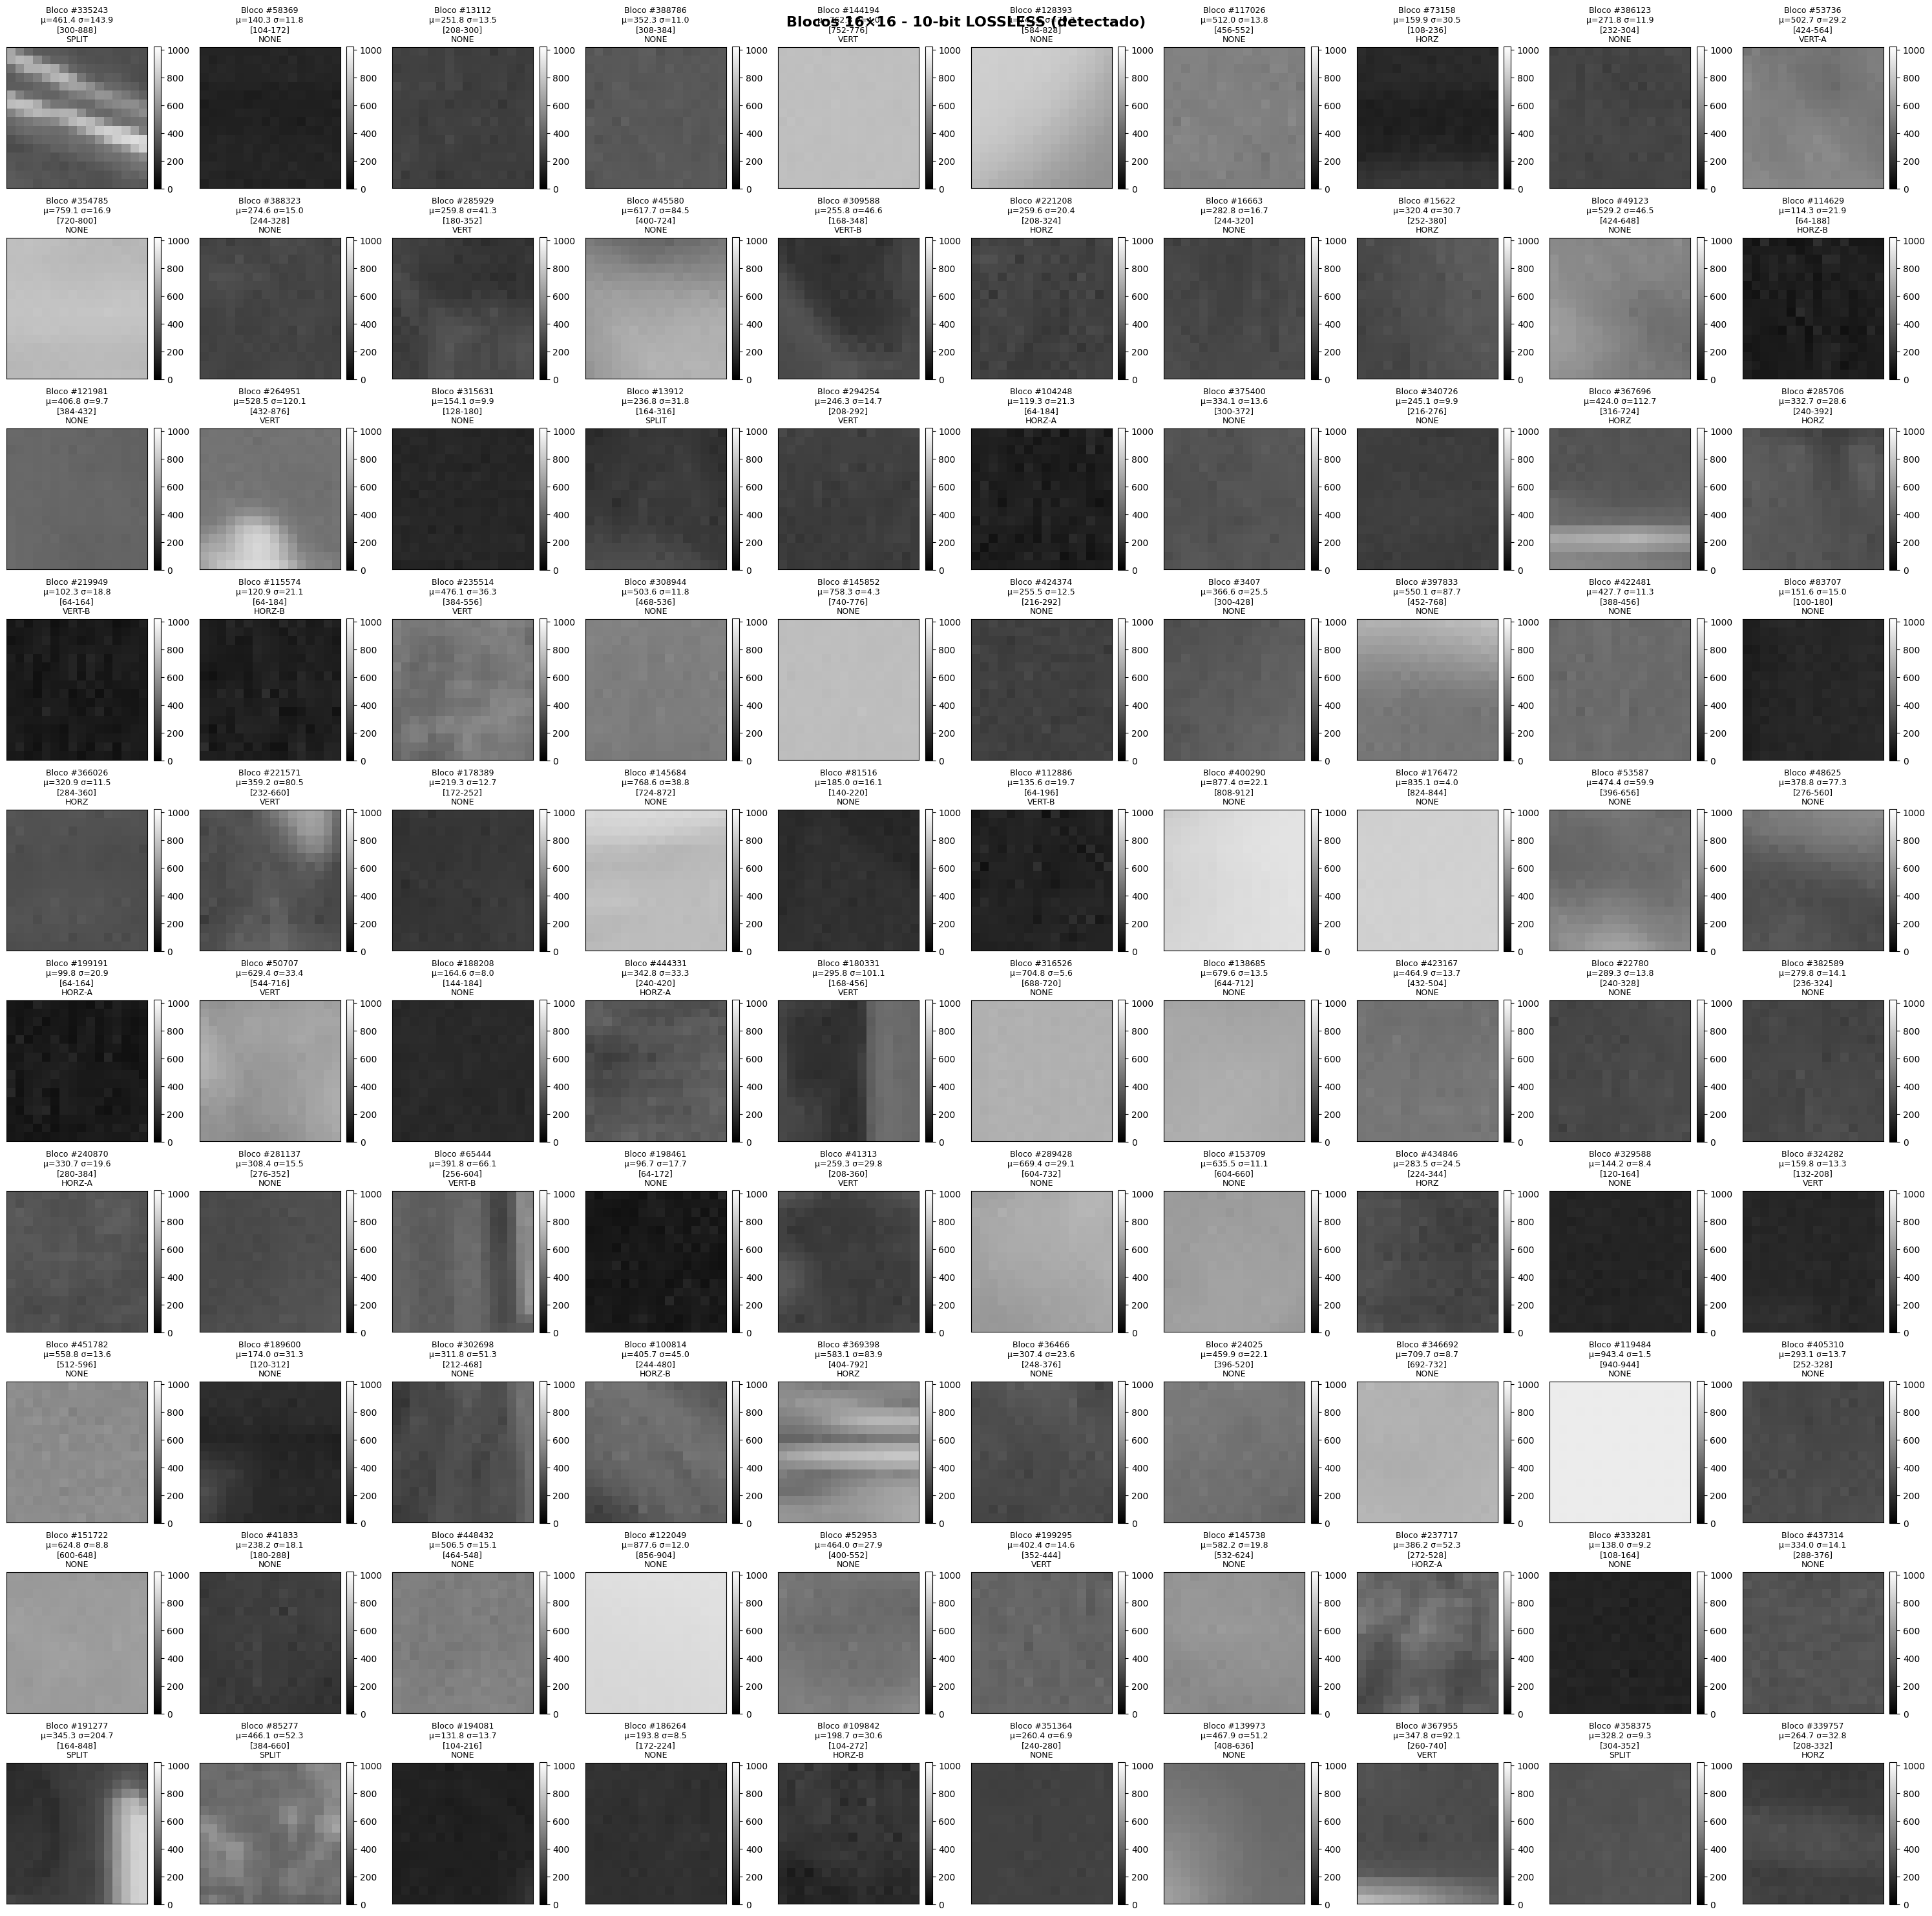

📈 Estatísticas dos 100 blocos visualizados:
  Média das médias: 386.62 ± 203.56
  Média dos desvios: 31.21 ± 32.57

📋 Modos de particionamento nos blocos visualizados:
  PARTITION_NONE: 60 (60.0%)
  PARTITION_HORZ: 9 (9.0%)
  PARTITION_VERT: 12 (12.0%)
  PARTITION_SPLIT: 5 (5.0%)
  PARTITION_HORZ_A: 5 (5.0%)
  PARTITION_HORZ_B: 4 (4.0%)
  PARTITION_VERT_A: 1 (1.0%)
  PARTITION_VERT_B: 4 (4.0%)


In [85]:
# Visualização dos blocos selecionados
if 'all_blocks_array' in locals() and len(all_blocks_array) > 0:
    
    # Determinar range de valores para visualização (baseado no formato detectado)
    if format_info_global:
        vmax_display = format_info_global['max_value']
        format_name = format_info_global['format_name']
    else:
        # Fallback: usar max real dos dados
        vmax_display = int(np.max(all_blocks_array))
        format_name = 'Auto-detectado'
    
    print(f"🎨 Visualizando com range: 0-{vmax_display} ({format_name})")
    
    # Selecionar blocos aleatórios para visualização
    n_available = len(all_blocks_array)
    n_to_show = min(n_blocks_to_show, n_available)
    
    # Índices aleatórios
    random.seed(42)
    random_indices = random.sample(range(n_available), n_to_show)
    selected_blocks = all_blocks_array[random_indices]
    selected_labels = all_labels_array[random_indices] if 'all_labels_array' in locals() else None
    
    # Calcular dimensões do grid
    grid_rows = (n_to_show + grid_cols - 1) // grid_cols
    
    # Criar figura
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 3, grid_rows * 3))
    fig.suptitle(f'Blocos {block_size}×{block_size} - {format_name}', fontsize=16, fontweight='bold')
    
    # Garantir que axes é sempre 2D
    if grid_rows == 1:
        axes = axes.reshape(1, -1)
    elif grid_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Plotar cada bloco
    for i in range(grid_rows * grid_cols):
        row = i // grid_cols
        col = i % grid_cols
        ax = axes[row, col]
        
        if i < n_to_show:
            block = selected_blocks[i]
            stats = get_block_statistics(block)
            
            # Mostrar o bloco (com range ajustado)
            im = ax.imshow(block, cmap=colormap, vmin=0, vmax=vmax_display)
            
            # Título com estatísticas e modo de particionamento
            title = f'Bloco #{random_indices[i]}\n'
            title += f'μ={stats["mean"]:.1f} σ={stats["std"]:.1f}\n'
            title += f'[{stats["min"]}-{stats["max"]}]\n'
            
            # Adicionar modo de particionamento se disponível
            if selected_labels is not None:
                partition_mode = get_partition_mode_name(selected_labels[i])
                # Usar versão abreviada para economizar espaço
                mode_short = partition_mode.replace('PARTITION_', '').replace('_', '-')
                title += f'{mode_short}'
            else:
                title += 'NO-LABEL'
                
            ax.set_title(title, fontsize=9)
            
            # Colorbar
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            # Esconder eixos vazios
            ax.axis('off')
        
        # Remover ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    print(f"📈 Estatísticas dos {n_to_show} blocos visualizados:")
    block_means = [get_block_statistics(block)['mean'] for block in selected_blocks]
    block_stds = [get_block_statistics(block)['std'] for block in selected_blocks]
    
    print(f"  Média das médias: {np.mean(block_means):.2f} ± {np.std(block_means):.2f}")
    print(f"  Média dos desvios: {np.mean(block_stds):.2f} ± {np.std(block_stds):.2f}")
    
    # Estatísticas dos modos nos blocos visualizados
    if selected_labels is not None:
        unique_vis_modes, vis_counts = np.unique(selected_labels, return_counts=True)
        print(f"\n📋 Modos de particionamento nos blocos visualizados:")
        for mode, count in zip(unique_vis_modes, vis_counts):
            mode_name = get_partition_mode_name(mode)
            percentage = (count / len(selected_labels)) * 100
            print(f"  {mode_name}: {count} ({percentage:.1f}%)")
    
else:
    print("❌ Nenhum bloco disponível para visualização")

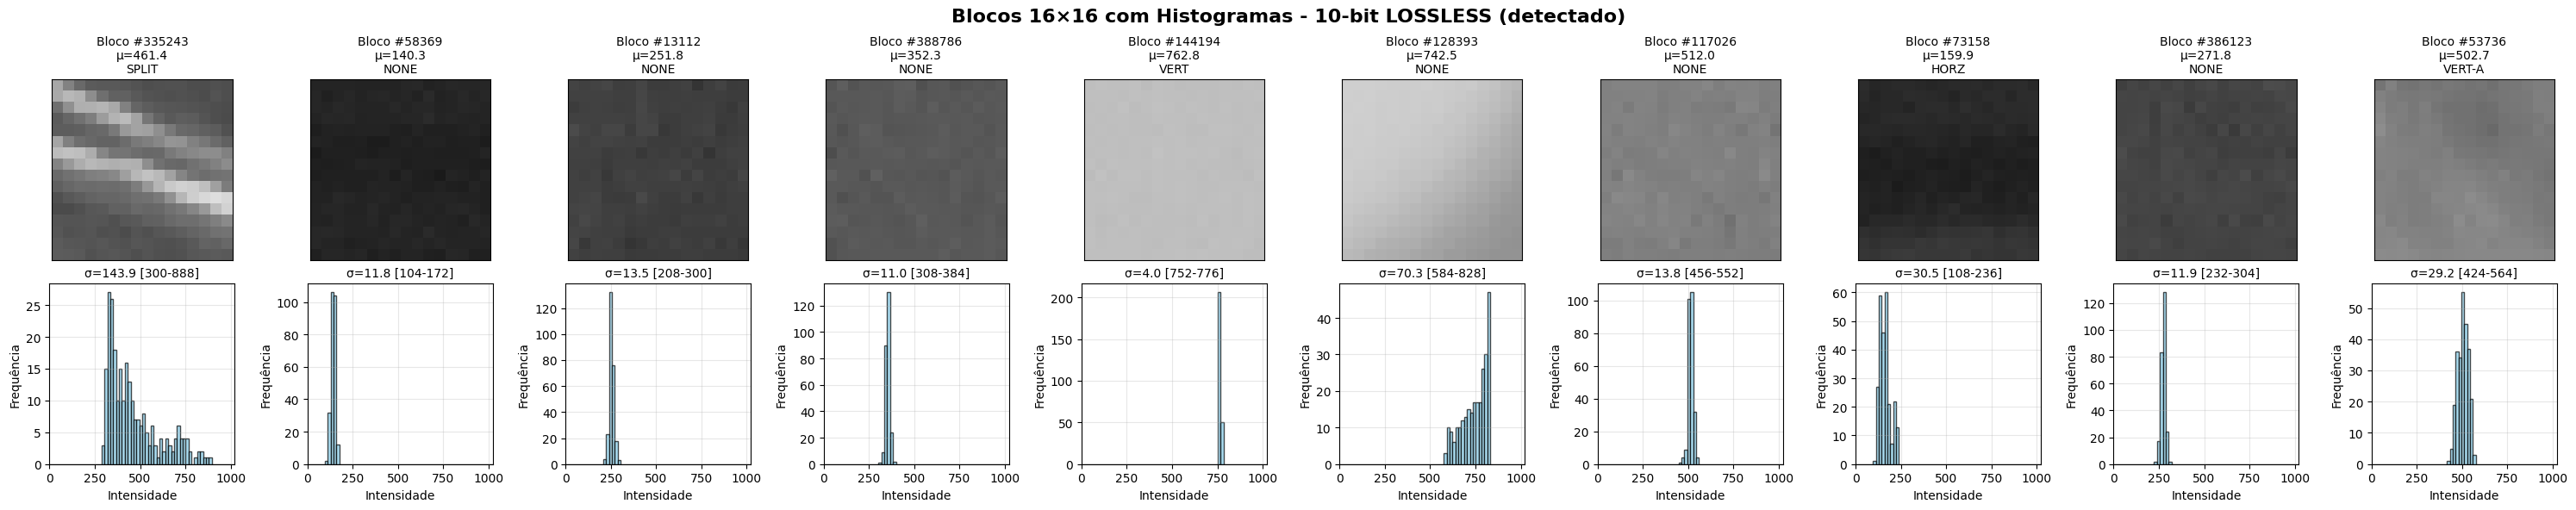

In [86]:
# Visualização com histogramas de intensidade
if 'selected_blocks' in locals() and len(selected_blocks) > 0:
    
    # Determinar range para visualização
    if format_info_global:
        vmax_display = format_info_global['max_value']
        format_name = format_info_global['format_name']
    else:
        vmax_display = int(np.max(all_blocks_array))
        format_name = 'Auto'
    
    # Criar figura com subplots para imagens e histogramas
    n_samples = min(10, len(selected_blocks))  # Máximo 10 para não ficar muito carregado
    
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 3, 6))
    fig.suptitle(f'Blocos {block_size}×{block_size} com Histogramas - {format_name}', 
                 fontsize=16, fontweight='bold')
    
    # Garantir que axes é 2D
    if n_samples == 1:
        axes = axes.reshape(2, 1)
    
    for i in range(n_samples):
        block = selected_blocks[i]
        stats = get_block_statistics(block)
        
        # Imagem do bloco (linha superior)
        ax_img = axes[0, i]
        im = ax_img.imshow(block, cmap=colormap, vmin=0, vmax=vmax_display)
        
        # Título com modo de particionamento
        title = f'Bloco #{random_indices[i]}\nμ={stats["mean"]:.1f}\n'
        if selected_labels is not None:
            partition_mode = get_partition_mode_name(selected_labels[i])
            mode_short = partition_mode.replace('PARTITION_', '').replace('_', '-')
            title += f'{mode_short}'
        else:
            title += 'NO-LABEL'
            
        ax_img.set_title(title, fontsize=10)
        ax_img.set_xticks([])
        ax_img.set_yticks([])
        
        # Histograma (linha inferior)
        ax_hist = axes[1, i]
        # Ajustar número de bins baseado no range
        n_bins = 64 if vmax_display > 255 else 32
        ax_hist.hist(block.flatten(), bins=n_bins, alpha=0.7, color='skyblue', edgecolor='black', range=(0, vmax_display))
        ax_hist.set_xlabel('Intensidade')
        ax_hist.set_ylabel('Frequência')
        ax_hist.set_title(f'σ={stats["std"]:.1f} [{stats["min"]}-{stats["max"]}]', fontsize=10)
        ax_hist.grid(True, alpha=0.3)
        ax_hist.set_xlim(0, vmax_display)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Nenhum bloco disponível para análise de histograma")

📊 ANÁLISE ESTATÍSTICA COMPLETA - 453961 blocos 16×16
Formato: 10-bit LOSSLESS (detectado) (10-bit, range 0-1023)
MÉDIAS DOS BLOCOS:
  Média: 402.18
  Desvio padrão: 206.05
  Min: 91.55
  Max: 943.38
  Mediana: 351.08

DESVIOS PADRÃO DOS BLOCOS:
  Média: 30.68
  Desvio padrão: 33.63
  Min: 0.56
  Max: 324.17
  Mediana: 18.65


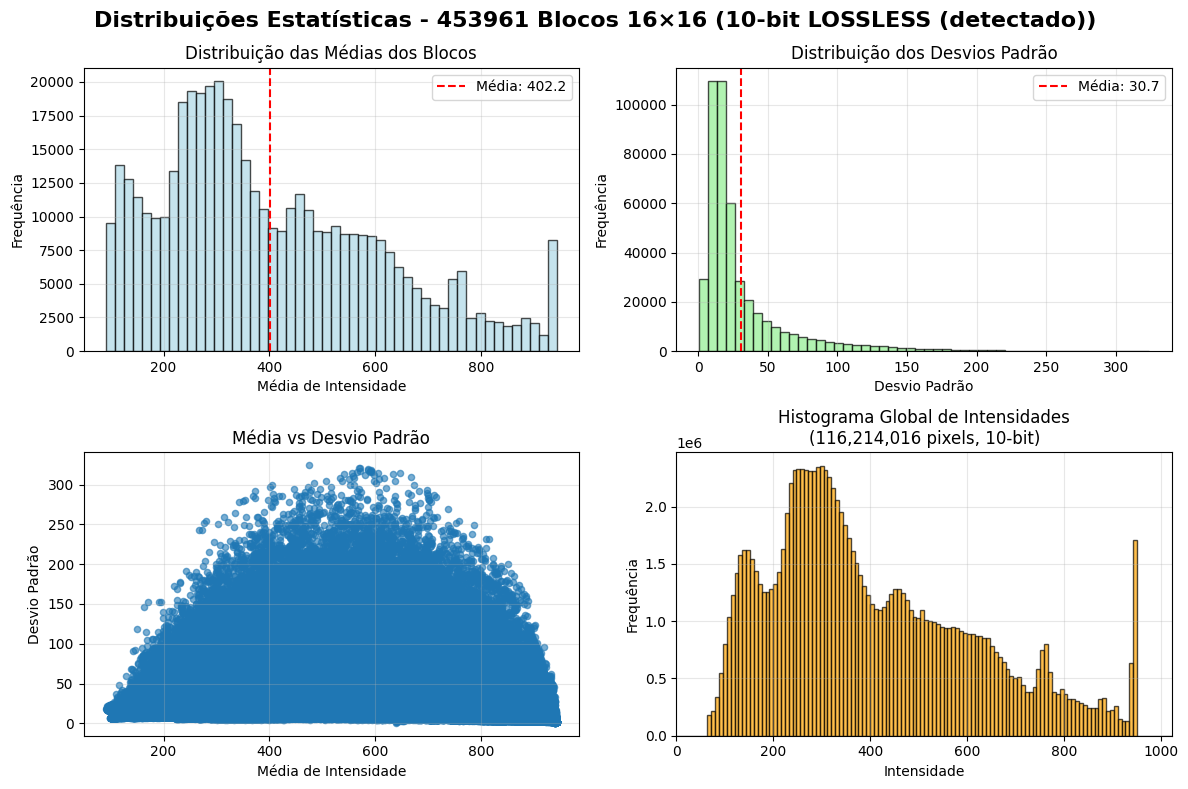


📁 ARQUIVOS CARREGADOS:
  HoneyBee_3840x2160_120fps_420_10bit: 28864 blocos (10-bit LOSSLESS (detectado))
  ShakeNDry_3840x2160_120fps_420_10bit: 29422 blocos (10-bit LOSSLESS (detectado))
  CityAlley_3840x2160_50fps_420_10bit: 27302 blocos (10-bit LOSSLESS (detectado))
  Beauty_3840x2160_120fps_420_10bit: 31776 blocos (10-bit LOSSLESS (detectado))
  SunBath_3840x2160_50fps_420_10bit: 25181 blocos (10-bit LOSSLESS (detectado))
  Bosphorus_3840x2160_120fps_420_10bit: 26039 blocos (10-bit LOSSLESS (detectado))
  ReadySetGo_3840x2160_120fps_420_10bit: 29876 blocos (10-bit LOSSLESS (detectado))
  Lips_3840x2160_120fps_420_10bit: 32220 blocos (10-bit LOSSLESS (detectado))
  RiverBank_3840x2160_50fps_420_10bit: 28396 blocos (10-bit LOSSLESS (detectado))
  FlowerKids_3840x2160_50fps_420_10bit: 24502 blocos (10-bit LOSSLESS (detectado))
  FlowerPan_3840x2160_50fps_420_10bit: 31652 blocos (10-bit LOSSLESS (detectado))
  Twilight_3840x2160_50fps_420_10bit: 27109 blocos (10-bit LOSSLESS (detectad

In [87]:
# Análise estatística completa dos blocos carregados
if 'all_blocks_array' in locals() and len(all_blocks_array) > 0:
    
    # Determinar formato
    if format_info_global:
        format_name = format_info_global['format_name']
        bit_depth = format_info_global['bit_depth']
        vmax_display = format_info_global['max_value']
    else:
        format_name = 'Auto-detectado'
        bit_depth = 8 if np.max(all_blocks_array) <= 255 else 10
        vmax_display = int(np.max(all_blocks_array))
    
    print(f"📊 ANÁLISE ESTATÍSTICA COMPLETA - {len(all_blocks_array)} blocos {block_size}×{block_size}")
    print(f"Formato: {format_name} ({bit_depth}-bit, range 0-{vmax_display})")
    print("=" * 70)
    
    # Calcular estatísticas para todos os blocos
    all_means = []
    all_stds = []
    all_mins = []
    all_maxs = []
    
    for block in all_blocks_array:
        stats = get_block_statistics(block)
        all_means.append(stats['mean'])
        all_stds.append(stats['std'])
        all_mins.append(stats['min'])
        all_maxs.append(stats['max'])
    
    # Converter para arrays numpy
    all_means = np.array(all_means)
    all_stds = np.array(all_stds)
    all_mins = np.array(all_mins)
    all_maxs = np.array(all_maxs)
    
    # Estatísticas das estatísticas
    print(f"MÉDIAS DOS BLOCOS:")
    print(f"  Média: {np.mean(all_means):.2f}")
    print(f"  Desvio padrão: {np.std(all_means):.2f}")
    print(f"  Min: {np.min(all_means):.2f}")
    print(f"  Max: {np.max(all_means):.2f}")
    print(f"  Mediana: {np.median(all_means):.2f}")
    
    print(f"\nDESVIOS PADRÃO DOS BLOCOS:")
    print(f"  Média: {np.mean(all_stds):.2f}")
    print(f"  Desvio padrão: {np.std(all_stds):.2f}")
    print(f"  Min: {np.min(all_stds):.2f}")
    print(f"  Max: {np.max(all_stds):.2f}")
    print(f"  Mediana: {np.median(all_stds):.2f}")
    
    # Visualização das distribuições estatísticas
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'Distribuições Estatísticas - {len(all_blocks_array)} Blocos {block_size}×{block_size} ({format_name})', 
                 fontsize=16, fontweight='bold')
    
    # Histograma das médias
    axes[0, 0].hist(all_means, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    axes[0, 0].set_title('Distribuição das Médias dos Blocos')
    axes[0, 0].set_xlabel('Média de Intensidade')
    axes[0, 0].set_ylabel('Frequência')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axvline(np.mean(all_means), color='red', linestyle='--', label=f'Média: {np.mean(all_means):.1f}')
    axes[0, 0].legend()
    
    # Histograma dos desvios padrão
    axes[0, 1].hist(all_stds, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Distribuição dos Desvios Padrão')
    axes[0, 1].set_xlabel('Desvio Padrão')
    axes[0, 1].set_ylabel('Frequência')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axvline(np.mean(all_stds), color='red', linestyle='--', label=f'Média: {np.mean(all_stds):.1f}')
    axes[0, 1].legend()
    
    # Scatter plot: média vs desvio padrão
    axes[1, 0].scatter(all_means, all_stds, alpha=0.6, s=20)
    axes[1, 0].set_title('Média vs Desvio Padrão')
    axes[1, 0].set_xlabel('Média de Intensidade')
    axes[1, 0].set_ylabel('Desvio Padrão')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Histograma global de todas as intensidades
    all_pixels = all_blocks_array.flatten()
    n_bins_global = 128 if vmax_display > 255 else 64
    axes[1, 1].hist(all_pixels, bins=n_bins_global, alpha=0.7, color='orange', edgecolor='black', range=(0, vmax_display))
    axes[1, 1].set_title(f'Histograma Global de Intensidades\n({len(all_pixels):,} pixels, {bit_depth}-bit)')
    axes[1, 1].set_xlabel('Intensidade')
    axes[1, 1].set_ylabel('Frequência')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim(0, vmax_display)
    
    plt.tight_layout()
    plt.show()
    
    # Informações adicionais sobre os arquivos carregados
    print(f"\n📁 ARQUIVOS CARREGADOS:")
    for info in file_info:
        print(f"  {info['sequence']}: {info['n_blocks']} blocos ({info['format']})")
    
else:
    print("❌ Nenhum dado disponível para análise estatística")

📊 ANÁLISE DOS MODOS DE PARTICIONAMENTO
Total de blocos analisados: 453961
Modos únicos encontrados: 8


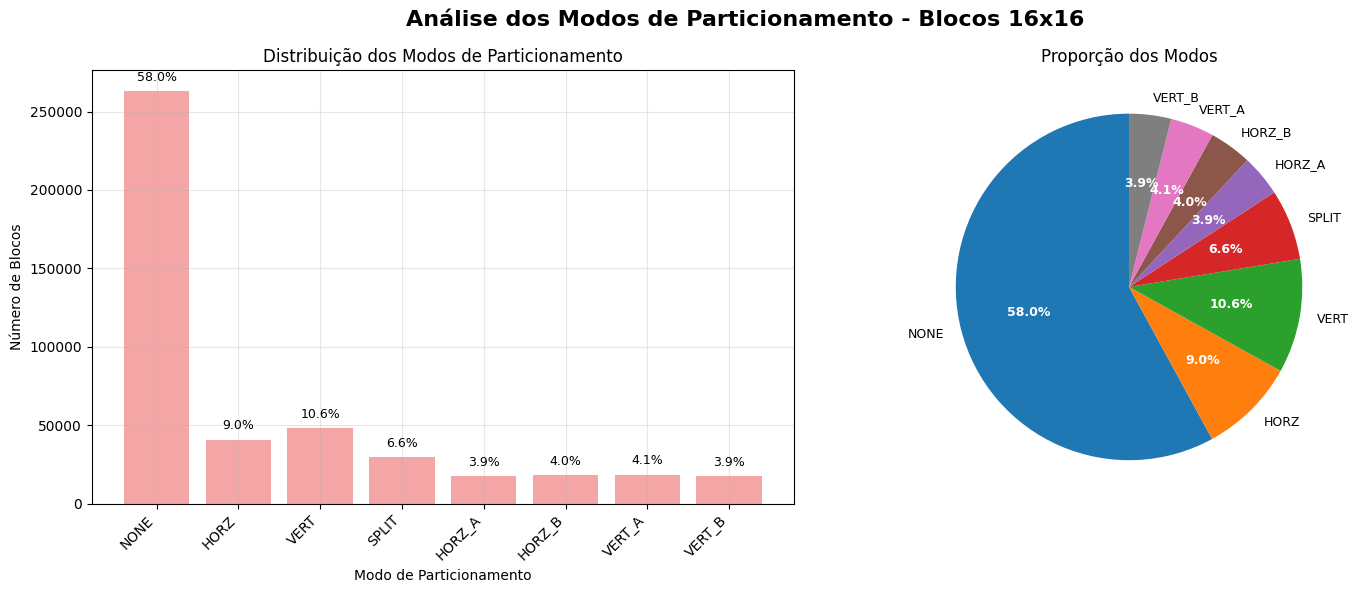


📋 TABELA DETALHADA DOS MODOS:
Modo                 Índice   Contagem   Percentual  
----------------------------------------------------
PARTITION_NONE       0        263105     57.96       %
PARTITION_HORZ       1        40822      8.99        %
PARTITION_VERT       2        48321      10.64       %
PARTITION_SPLIT      3        29904      6.59        %
PARTITION_HORZ_A     4        17543      3.86        %
PARTITION_HORZ_B     5        17996      3.96        %
PARTITION_VERT_A     6        18478      4.07        %
PARTITION_VERT_B     7        17792      3.92        %

📈 ESTATÍSTICAS DE INTENSIDADE POR MODO:
Modo                 Média μ    Desvio σ   Min      Max     
----------------------------------------------------------
PARTITION_NONE       428.8      20.4       60       944     
PARTITION_HORZ       440.5      50.5       60       944     
PARTITION_VERT       383.3      43.2       60       944     
PARTITION_SPLIT      292.2      37.0       60       944     
PARTITION_HORZ_A 

In [88]:
# Análise dos modos de particionamento
if 'all_labels_array' in locals() and len(all_labels_array) > 0:
    
    print(f"📊 ANÁLISE DOS MODOS DE PARTICIONAMENTO")
    print("=" * 50)
    
    # Estatísticas gerais
    unique_modes, mode_counts = np.unique(all_labels_array, return_counts=True)
    total_blocks = len(all_labels_array)
    
    print(f"Total de blocos analisados: {total_blocks}")
    print(f"Modos únicos encontrados: {len(unique_modes)}")
    
    # Criar visualização dos modos de particionamento
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Análise dos Modos de Particionamento - Blocos {block_size}x{block_size}', 
                 fontsize=16, fontweight='bold')
    
    # Gráfico de barras dos modos
    mode_names = [get_partition_mode_name(mode).replace('PARTITION_', '') for mode in unique_modes]
    
    ax1 = axes[0]
    bars = ax1.bar(range(len(unique_modes)), mode_counts, alpha=0.7, color='lightcoral')
    ax1.set_title('Distribuição dos Modos de Particionamento')
    ax1.set_xlabel('Modo de Particionamento')
    ax1.set_ylabel('Número de Blocos')
    ax1.set_xticks(range(len(unique_modes)))
    ax1.set_xticklabels(mode_names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Adicionar percentuais nas barras
    for i, (bar, count) in enumerate(zip(bars, mode_counts)):
        percentage = (count / total_blocks) * 100
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total_blocks*0.01,
                f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Gráfico de pizza
    ax2 = axes[1]
    wedges, texts, autotexts = ax2.pie(mode_counts, labels=mode_names, autopct='%1.1f%%', 
                                      startangle=90, textprops={'fontsize': 9})
    ax2.set_title('Proporção dos Modos')
    
    # Melhorar a legibilidade do gráfico de pizza
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()
    
    # Tabela detalhada
    print(f"\n📋 TABELA DETALHADA DOS MODOS:")
    print(f"{'Modo':<20} {'Índice':<8} {'Contagem':<10} {'Percentual':<12}")
    print("-" * 52)
    
    for mode, count in zip(unique_modes, mode_counts):
        mode_name = get_partition_mode_name(mode)
        percentage = (count / total_blocks) * 100
        print(f"{mode_name:<20} {mode:<8} {count:<10} {percentage:<12.2f}%")
    
    # Análise estatística por modo (se houver blocos suficientes)
    if 'all_blocks_array' in locals():
        print(f"\n📈 ESTATÍSTICAS DE INTENSIDADE POR MODO:")
        print(f"{'Modo':<20} {'Média μ':<10} {'Desvio σ':<10} {'Min':<8} {'Max':<8}")
        print("-" * 58)
        
        for mode in unique_modes:
            if np.sum(all_labels_array == mode) >= 10:  # Pelo menos 10 blocos
                mode_blocks = all_blocks_array[all_labels_array == mode]
                mode_means = [np.mean(block) for block in mode_blocks]
                mode_stds = [np.std(block) for block in mode_blocks]
                mode_mins = [np.min(block) for block in mode_blocks]
                mode_maxs = [np.max(block) for block in mode_blocks]
                
                avg_mean = np.mean(mode_means)
                avg_std = np.mean(mode_stds)
                overall_min = np.min(mode_mins)
                overall_max = np.max(mode_maxs)
                
                mode_name = get_partition_mode_name(mode)
                print(f"{mode_name:<20} {avg_mean:<10.1f} {avg_std:<10.1f} {overall_min:<8} {overall_max:<8}")
            
else:
    print("❌ Nenhuma label de particionamento disponível para análise")

🎯 Visualizando blocos do modo: PARTITION_NONE
📊 Encontrados 263105 blocos do modo PARTITION_NONE


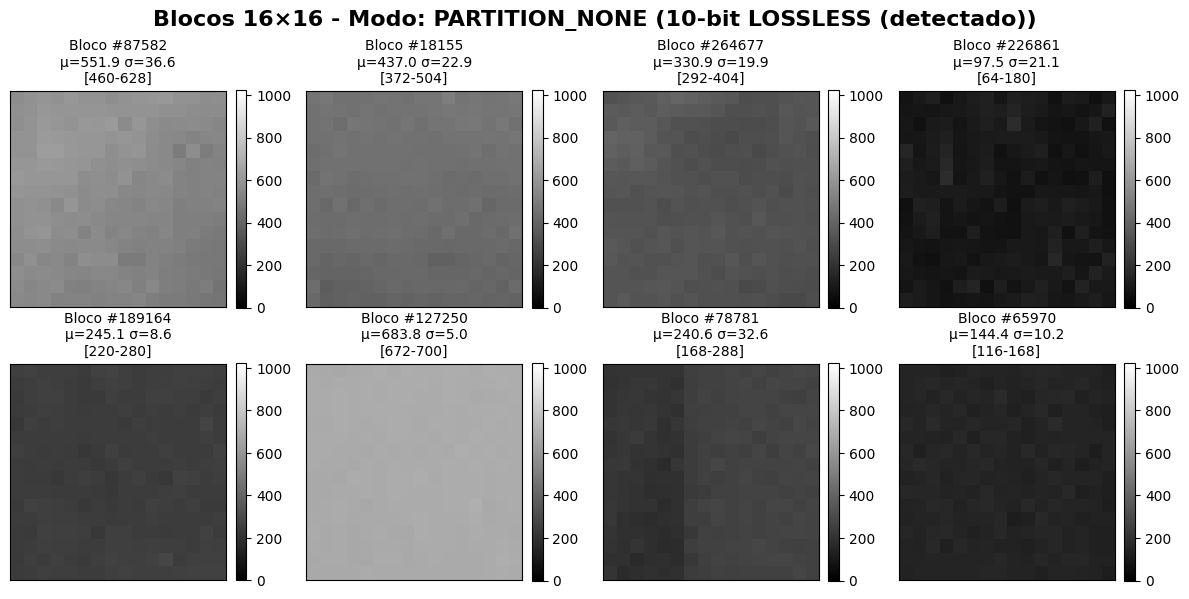


📈 Estatísticas para PARTITION_NONE:
  Total de blocos: 263105
  Média das intensidades: 428.79 ± 216.39
  Desvio padrão médio: 20.43 ± 19.99
  Range de médias: 92.6 - 943.4


In [89]:
# Visualização por modo de particionamento específico
if 'all_blocks_array' in locals() and 'all_labels_array' in locals():
    
    # Determinar range de visualização
    if format_info_global:
        vmax_display = format_info_global['max_value']
        format_name = format_info_global['format_name']
    else:
        vmax_display = int(np.max(all_blocks_array))
        format_name = 'Auto'
    
    # CONFIGURAÇÃO: Escolha o modo que deseja visualizar
    target_mode = 0  # 0=PARTITION_NONE, 1=PARTITION_HORZ, 2=PARTITION_VERT, etc.
    n_samples_per_mode = 8  # Número de amostras para mostrar
    
    target_mode_name = get_partition_mode_name(target_mode)
    print(f"🎯 Visualizando blocos do modo: {target_mode_name}")
    
    # Encontrar blocos do modo específico
    mode_indices = np.where(all_labels_array == target_mode)[0]
    
    if len(mode_indices) == 0:
        print(f"❌ Nenhum bloco encontrado para o modo {target_mode_name}")
    else:
        print(f"📊 Encontrados {len(mode_indices)} blocos do modo {target_mode_name}")
        
        # Selecionar amostras aleatórias
        n_to_show = min(n_samples_per_mode, len(mode_indices))
        random.seed(42)
        selected_mode_indices = random.sample(list(mode_indices), n_to_show)
        
        # Calcular dimensões do grid
        grid_cols_mode = 4
        grid_rows_mode = (n_to_show + grid_cols_mode - 1) // grid_cols_mode
        
        # Criar figura
        fig, axes = plt.subplots(grid_rows_mode, grid_cols_mode, 
                                figsize=(grid_cols_mode * 3, grid_rows_mode * 3))
        fig.suptitle(f'Blocos {block_size}×{block_size} - Modo: {target_mode_name} ({format_name})', 
                     fontsize=16, fontweight='bold')
        
        # Garantir que axes é sempre 2D
        if grid_rows_mode == 1:
            axes = axes.reshape(1, -1)
        elif grid_cols_mode == 1:
            axes = axes.reshape(-1, 1)
            
        # Plotar cada bloco do modo específico
        for i in range(grid_rows_mode * grid_cols_mode):
            row = i // grid_cols_mode
            col = i % grid_cols_mode
            ax = axes[row, col]
            
            if i < n_to_show:
                block_idx = selected_mode_indices[i]
                block = all_blocks_array[block_idx]
                stats = get_block_statistics(block)
                
                # Mostrar o bloco (com range ajustado)
                im = ax.imshow(block, cmap=colormap, vmin=0, vmax=vmax_display)
                
                # Título com estatísticas
                title = f'Bloco #{block_idx}\n'
                title += f'μ={stats["mean"]:.1f} σ={stats["std"]:.1f}\n'
                title += f'[{stats["min"]}-{stats["max"]}]'
                ax.set_title(title, fontsize=10)
                
                # Colorbar
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            else:
                # Esconder eixos vazios
                ax.axis('off')
            
            # Remover ticks
            ax.set_xticks([])
            ax.set_yticks([])
        
        plt.tight_layout()
        plt.show()
        
        # Estatísticas do modo específico
        mode_blocks = all_blocks_array[mode_indices]
        mode_means = [np.mean(block) for block in mode_blocks]
        mode_stds = [np.std(block) for block in mode_blocks]
        
        print(f"\n📈 Estatísticas para {target_mode_name}:")
        print(f"  Total de blocos: {len(mode_blocks)}")
        print(f"  Média das intensidades: {np.mean(mode_means):.2f} ± {np.std(mode_means):.2f}")
        print(f"  Desvio padrão médio: {np.mean(mode_stds):.2f} ± {np.std(mode_stds):.2f}")
        print(f"  Range de médias: {np.min(mode_means):.1f} - {np.max(mode_means):.1f}")
        
else:
    print("❌ Dados não disponíveis para análise por modo")

## Como usar este notebook

**1. Configuração de parâmetros:**
   - Altere a variável `block_size` para escolher o tamanho (8, 16, 32, ou 64)
   - Ajuste `n_blocks_to_show` para definir quantos blocos visualizar
   - Modifique `colormap` para mudar a paleta de cores
   - Configure `grid_cols` para alterar o layout do grid
   - Na célula "Visualização por modo específico", altere `target_mode` para ver blocos de um modo particular

**2. Detecção Automática de Formato:**
   - ✅ **8-bit (scripts antigos)**: Detecta arquivos com 1 byte/pixel (range 0-255)
   - ✅ **10-bit LOSSLESS (novo script)**: Detecta arquivos com 2 bytes/pixel (range 0-1023)
   - O notebook ajusta automaticamente:
     - Tipo de dado (uint8 vs uint16)
     - Range de visualização (0-255 vs 0-1023)
     - Número de bins dos histogramas
     - Informações exibidas nos logs

**3. Resultados:**
   - **Grid principal**: Mostra N blocos aleatórios com estatísticas e modo de particionamento
   - **Histogramas**: Análise de distribuição de intensidades com modos
   - **Análise de modos**: Distribuição e estatísticas dos modos de particionamento
   - **Visualização por modo**: Blocos filtrados por modo específico
   - **Estatísticas globais**: Resumo completo de todos os blocos carregados

**4. Interpretação:**
   - **Valores de intensidade**:
     - 8-bit: 0-255 (convertidos de 10-bit para 8-bit, COM PERDA)
     - 10-bit LOSSLESS: 0-1023 (precisão completa, SEM PERDA)
   - **μ (mu)**: Média de intensidade do bloco
   - **σ (sigma)**: Desvio padrão (variabilidade)
   - **[min-max]**: Range de intensidades no bloco
   - **Modos de particionamento**: NONE, HORZ, VERT, SPLIT, HORZ-A, HORZ-B, VERT-A, VERT-B, HORZ-4, VERT-4

**5. Formatos de arquivos:**
   
   **Arquivos 8-bit (antigos)**:
   - Tipo: uint8 (1 byte/pixel)
   - Range: 0-255
   - Perda: Sim (2 bits perdidos na conversão 10→8)
   - Tamanho: `n_blocks × block_size² × 1 byte`
   
   **Arquivos 10-bit LOSSLESS (novos)**:
   - Tipo: uint16 little-endian (2 bytes/pixel)
   - Range: 0-1023
   - Perda: Não (precisão total)
   - Tamanho: `n_blocks × block_size² × 2 bytes`
   
   **Labels**:
   - Arquivos binários int32 do diretório `labels`
   - Relação 1:1 com blocos
   - Gerados pelos scripts de processamento AV1

**6. Modos de particionamento AV1:**
   - **PARTITION_NONE (0)**: Sem subdivisão
   - **PARTITION_HORZ (1)**: Divisão horizontal
   - **PARTITION_VERT (2)**: Divisão vertical  
   - **PARTITION_SPLIT (3)**: Divisão em 4 partes
   - **PARTITION_HORZ_A/B (4/5)**: Divisões horizontais assimétricas
   - **PARTITION_VERT_A/B (6/7)**: Divisões verticais assimétricas
   - **PARTITION_HORZ_4/VERT_4 (8/9)**: Divisões em 4 partes horizontais/verticais